In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -O Jan.parquet
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -O Feb.parquet

--2022-05-22 16:01:57--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.113.3
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘Jan.parquet’

Jan.parquet         100%[===================>]  11.33M  52.4MB/s    in 0.2s    

2022-05-22 16:01:57 (52.4 MB/s) - ‘Jan.parquet’ saved [11886281/11886281]

--2022-05-22 16:01:57--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.113.3
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘Feb.parquet’

Feb.parquet         100%[===================>]  10.15M  52.7MB

In [3]:
df = pd.read_parquet('/content/Jan.parquet')

In [4]:
df.sample(5)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
802794,B01437,2021-01-22 14:11:10,2021-01-22 14:13:59,NaN,216.0,None,B02944
957729,B01145,2021-01-26 20:44:24,2021-01-26 20:50:41,NaN,159.0,None,B02788
949869,B02157,2021-01-26 15:33:17,2021-01-26 16:27:33,NaN,265.0,None,B02157
1055245,B02799,2021-01-29 07:49:23,2021-01-29 08:03:07,NaN,89.0,None,B02799
977277,B02794,2021-01-27 10:45:22,2021-01-27 10:50:20,NaN,72.0,None,B02617


#Question 1
Read the data for January. How many records are there?

In [5]:
print(f'{df.shape[0]} records')

1154112 records


# Question 2
What's the average trip duration in January?

In [6]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

print(f'Average trip duration in Janury is {df.duration.mean()}')

Average trip duration in Janury is 19.1672240937939


Data preparation
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
How many records did you drop?

#Question 3
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

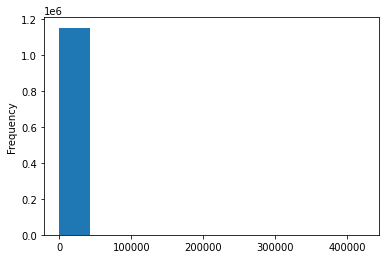

In [7]:
df.duration.plot(kind='hist');

In [8]:
df.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [9]:
was = df.shape[0]
df = df[(df.duration >= 1) & (df.duration <= 60)]

print(f'{was - df.shape[0]} records were dropped')

44286 records were dropped


In [10]:
print(f'fraction is {df.PUlocationID.isna().sum()/df.shape[0]}')

fraction is 0.8352732770722617


In [11]:
categorical = ['PUlocationID', 'DOlocationID']

In [12]:
df[categorical] = df[categorical].fillna(-1)
#here is warning to smth, i don't know

#Question 4
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

    Turn the dataframe into a list of dictionaries
    Fit a dictionary vectorizer
    Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

In [13]:
df[categorical] = df[categorical].astype(str)# иначе DictVectorizer воспринимает categorical как числовые фичи
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'Dimension of feature matrix is {X_train.shape}')

Dimension of feature matrix is (1109826, 525)


#Question 5
Now let's use the feature matrix from the previous step to train a model.

    Train a plain linear regression model with default parameters
    Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [14]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'RMSE is equal to {mean_squared_error(y_train, y_pred, squared=False)}')

RMSE is equal to 10.528519107210744


#Question 6
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [15]:
df_val = pd.read_parquet('/content/Feb.parquet')

df_val['duration'] = df_val.dropOff_datetime - df_val.pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]
df_val[categorical] = df_val[categorical].fillna(-1)
df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = df_val[target].values
y_pred = lr.predict(X_val)

print(f'RMSE on validation is equal to {mean_squared_error(y_val, y_pred, squared=False)}')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


RMSE on validation is equal to 11.014283196111764
